# Импорты

In [1]:
%%time
# здесь будем ставить все, чего нам не хватает
# !pip install missingno -q
# !pip install optuna -q
# !pip install tqdm -q
# !pip install seaborn -q
# !pip install torch -q
# !pip install scikit-learn -q
# !pip install statsmodels -q
# !pip install catboost -q
# !pip install shap -q

CPU times: total: 0 ns
Wall time: 3.81 μs


In [2]:
# Базовые библиотеки
import pandas as pd
import numpy as np
import logging
import time
import socket
import sys
import warnings
import seaborn as sns

# Визуализация
import matplotlib.pyplot as plt

# Базы данных
import psycopg2
from sqlalchemy import create_engine
import sqlalchemy

# Машинное обучение - модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# === Статистика ===
from phik import phik_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

# === Sklearn ===

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    RobustScaler,
    FunctionTransformer,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    KFold,
    cross_val_score,
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    roc_auc_score,
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Оптимизация гиперпараметров
import optuna
from optuna.samplers import TPESampler

# Интерпретация моделей
import shap

# Прогресс-бар
from tqdm import tqdm

# ИМПОРТ ФУНКЦИЙ ПРОЕКТА И КОНФИГУРАЦИИ
from func import (
    check_data,
    drop_duplicated,
    plot_combined,
    calc_target_correlations,
    plot_categorical_columns,
    plot_scatter_with_numerical,
    suggest_param,
    EarlyStoppingCallback
)

from creds import db_config

# НАСТРОЙКА ЛОГГИРОВАНИЯ
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

# ОТКЛЮЧЕНИЕ ПРЕДУПРЕЖДЕНИЙ
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Отключаем логи Optuna чтобы избежать дублирования
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

e:\my_github\yandex_practicum_ds\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Константы

In [3]:
RANDOM_STATE = 20
TEST_SIZE = 0.2
N_JOBS = 2
N_ITER = 10000 # число итераций для перебора и поиска лучших параметров
N_CROSS_VALL = 3
EARLY_STOP = 50

# Подключение к базе и получение данных

In [4]:
# Импортируем конфигурацию из отдельного файла
try:
    logger.info("Конфигурация загружена из creds.py")
except ImportError:
    logger.info("Файл creds.py не найден")
    db_config = {
        'user': input("Введите имя пользователя: "),
        'pwd': input("Введите пароль: "),
        'host': input("Введите хост: "),
        'port': input("Введите порт: "),
        'db': input("Введите название БД: ")
    }

2025-11-26 22:15:15 [INFO] __main__: Конфигурация загружена из creds.py


In [5]:
def check_host_availability():
    """Проверка доступности хоста"""
    try:
        socket.create_connection((db_config['host'], db_config['port']), timeout=10)
        logger.info("Хост доступен, можем подключаться и выгружать данные")
        return True
    except socket.error as e:
        logger.info(f"Хост недоступен: {e}")
        sys.exit("ОСТАНОВКА: Не удалось подключиться к базе данных. Дальнейшее выполнение невозможно.")

check_host_availability()

2025-11-26 22:15:15 [INFO] __main__: Хост доступен, можем подключаться и выгружать данные


True

In [6]:
# если с хостом все ок, то подключаемся и забираем данные
connection_string = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
engine = create_engine(connection_string)

def load_data_safe(engine, table_name_or_query, use_chunks=True, chunksize=300000):
    """Загружает данные - либо таблицу целиком, либо по SQL-запросу"""
    try:
        # Определяем тип загрузки
        if isinstance(table_name_or_query, str) and table_name_or_query.strip().upper().startswith('SELECT'):
            # Это SQL-запрос - загружаем напрямую
            logger.info(f"Загружаем данные по SQL-запросу...")
            result = pd.read_sql(table_name_or_query, engine)
            logger.info(f"Загружено: {result.shape[0]} строк, {result.shape[1]} столбцов")
            return result
        else:
            # Это имя таблицы
            table_name = table_name_or_query
            if use_chunks:
                # Загружаем по частям
                logger.info(f"Загружаем таблицу {table_name} по частям...")
                count_query = f"SELECT COUNT(*) FROM {table_name}"
                total_rows = pd.read_sql(count_query, engine).iloc[0,0]
                logger.info(f"Всего строк в {table_name}: {total_rows}")
                
                chunks = []
                for offset in range(0, total_rows, chunksize):
                    query = f"SELECT * FROM {table_name} LIMIT {chunksize} OFFSET {offset}"
                    chunk = pd.read_sql(query, engine)
                    chunks.append(chunk)
                    logger.info(f"Загружено {len(chunk)} строк (прогресс: {min(offset + chunksize, total_rows)}/{total_rows})")
                
                result = pd.concat(chunks, ignore_index=True)
                logger.info(f"{table_name}: {result.shape[0]} строк, {result.shape[1]} столбцов")
                return result
            else:
                # Загружаем целиком
                logger.info(f"Загружаем таблицу {table_name}...")
                result = pd.read_sql(f"SELECT * FROM {table_name}", engine)
                logger.info(f"{table_name}: {result.shape[0]} строк, {result.shape[1]} столбцов")
                return result
        
    except Exception as e:
        logger.error(f"Ошибка при загрузке: {e}")
        return None

def load_all_tables_safe(engine, tables_config):
    """Безопасная загрузка всех таблиц/запросов"""
    dataframes = {}
    
    for table_name, table_ref in tables_config.items():
        dataframes[table_name] = load_data_safe(engine, table_ref)
    
    return dataframes

In [7]:
logger.info("=== ЗАГРУЗКА ПОЛНЫХ ТАБЛИЦ ===")
full_tables_config = {
    'collisions': 'collisions',
    'parties': 'parties', 
    'vehicles': 'vehicles'
}

df_dict_full = load_all_tables_safe(engine, full_tables_config)

# Проверяем что все таблицы загружены
successful_tables = {k: v for k, v in df_dict_full.items() if v is not None}

if len(successful_tables) == len(full_tables_config):
    collisions_default = df_dict_full['collisions']
    parties_default = df_dict_full['parties']
    vehicles_default = df_dict_full['vehicles']
    logger.info("Все полные данные успешно загружены")
else:
    logger.warning(f"Загружены только таблицы: {list(successful_tables.keys())}")

2025-11-26 22:15:15 [INFO] __main__: === ЗАГРУЗКА ПОЛНЫХ ТАБЛИЦ ===
2025-11-26 22:15:15 [INFO] __main__: Загружаем таблицу collisions по частям...
2025-11-26 22:15:15 [INFO] __main__: Всего строк в collisions: 1400000
2025-11-26 22:15:23 [INFO] __main__: Загружено 300000 строк (прогресс: 300000/1400000)
2025-11-26 22:15:31 [INFO] __main__: Загружено 300000 строк (прогресс: 600000/1400000)
2025-11-26 22:15:40 [INFO] __main__: Загружено 300000 строк (прогресс: 900000/1400000)
2025-11-26 22:15:48 [INFO] __main__: Загружено 300000 строк (прогресс: 1200000/1400000)
2025-11-26 22:15:54 [INFO] __main__: Загружено 200000 строк (прогресс: 1400000/1400000)
2025-11-26 22:15:55 [INFO] __main__: collisions: 1400000 строк, 20 столбцов
2025-11-26 22:15:55 [INFO] __main__: Загружаем таблицу parties по частям...
2025-11-26 22:15:55 [INFO] __main__: Всего строк в parties: 2752408
2025-11-26 22:15:58 [INFO] __main__: Загружено 300000 строк (прогресс: 300000/2752408)
2025-11-26 22:16:02 [INFO] __main__: З

In [8]:
collisions_default.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [9]:
parties_default.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [10]:
vehicles_default.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


Да, много данных. Посмотрим, как это число изменится если мы сразу получим только то, что нам нужно

В тз у нас есть ограничения на выборку - учтем их сразу в запросах, чтобы не тащить все данные.  
- Для модели выбрать тип виновника — только машина (car).  
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).  
- Для моделирования ограничиться данными за 2012 год — они самые свежие. Т.е. берем все что до 2013 года.  

Также отберем только нужные признаки, который будут полезны для модели.

# Отбор признаков для модели предсказания виновности в ДТП

## Признаки для модели

Из таблицы `collisions`

| Признак | Описание |
|---------|-------------|
| `WEATHER_1` | Погодные условия напрямую влияют на видимость и управляемость транспортным средством |
| `ROAD_SURFACE` | Состояние дорожного покрытия значительно воздействует на риск возникновения ДТП |
| `LIGHTING` | Уровень освещённости влияет на видимость и скорость реакции водителя |
| `INTERSECTION` | Перекрестки являются зонами повышенной аварийности и сложности манёвров |
| `LOCATION_TYPE` | Тип дороги определяет характер движения и потенциальные риски |
| `ROAD_CONDITION_1` | Дополнительные дорожные условия создают дополнительные факторы риска |
| `DIRECTION` | Направление движения само по себе не является информативным признаком, но пусть будет |
| `DISTANCE` | Расстояние от главной дороги без дополнительного контекста не информативно |

Из таблицы `parties`

| Признак | Описание |
|---------|-------------|
| `CELLPHONE_IN_USE` | Использование телефона за рулём приводит к отвлечению внимания и нарушениям |

Из таблицы `vehicles`

| Признак | Описание |
|---------|-------------|
| `VEHICLE_AGE` | Обязателен по ТЗ - возраст автомобиля может влиять на техническую исправность и безопасность |
| `VEHICLE_TYPE` | Тип кузова может влиять на управляемость и поведение транспортного средства |

---

## Признаки для исключения из модели

Технические и идентификационные признаки
- `CASE_ID`, `ID` - уникальные идентификаторы, не несут прогнозной способности
- `PARTY_NUMBER` - технический номер участника в рамках ДТП

Географические признаки
- `COUNTY_CITY_LOCATION`, `COUNTY_LOCATION` - без детальных карт и анализа дорожной инфраструктуры сложно интерпретировать

Временные признаки
- `COLLISION_DATE`, `COLLISION_TIME` - рекомендуется вынести в отдельный анализ сезонности и времени суток, но из них мы сделаем доп фичи в последствии

Избыточные и производные признаки
- `PRIMARY_COLLISION_FACTOR` - дублирует информацию из `PCF_VIOLATION_CATEGORY`, но в более обобщённой форме
- `PARTY_COUNT` - количество участников ДТП слабо коррелирует с виновностью конкретного водителя
- `MOTOR_VEHICLE_INVOLVED_WITH` - тип второго участника менее важен, чем действия самого виновника
- `INSURANCE_PREMIUM` - страховая премия является скорее следствием, чем причиной ДТП

Признаки которые явно будут утечкой данных  
| Признак | Описание |
|---------|-------------|
| `PARTY_SOBRIETY` | Критический признак - состояние трезвости является ключевым фактором определения виновника |
| `PCF_VIOLATION_CATEGORY` | Ключевой признак - категории нарушений ПДД напрямую коррелируют с виновностью |
| `TYPE_OF_COLLISION` | Тип столкновения может указывать на действия виновника аварии |
| `PARTY_DRUG_PHYSICAL` | Важный признак - физическое состояние водителя напрямую влияет на виновность |

Ретроспектива небольшая:  
1) после мая 2012 у нас данных почти нет, значит для нормальной оценки сезонности надо брать все ДО 2012 года, иначе получим некорректные данные при расчетах  
2) party_drug_physical и location_type - практически пустые признаки, вообще не берем их, чтобы не мешали и не фонили

In [11]:
logger.info("=== ЗАГРУЗКА ОТФИЛЬТРОВАННЫХ ТАБЛИЦ ===")

# оптимизированные запросы с учетом отбора признаков
query = """
SELECT 
    -- Из collisions
    -- c.case_id,
    c.weather_1,
    c.road_surface,
    c.lighting,
    c.intersection,
    -- c.location_type,
    c.pcf_violation_category,
    c.type_of_collision,
    c.road_condition_1,
    c.direction,
    c.distance,
    c.collision_date::date,
    c.collision_time::time,
    
    -- Из parties
    p.party_number,
    p.at_fault,
    -- p.party_drug_physical,
    p.party_sobriety,
    p.cellphone_in_use,
    
    -- Из vehicles
    v.vehicle_type,
    v.vehicle_age,
    v.vehicle_transmission
    
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE c.collision_date < '2012-12-31'
-- WHERE c.collision_date < '2012-01-01'
    AND  c.collision_date > '2008-12-31'
    AND c.collision_damage <> 'scratch'
    AND p.party_type = 'car'
    AND v.vehicle_age < 11
"""

filtered_tables_config = {
    'df': query
}

2025-11-26 22:16:35 [INFO] __main__: === ЗАГРУЗКА ОТФИЛЬТРОВАННЫХ ТАБЛИЦ ===


In [12]:
# Загружаем отфильтрованные таблицы
df_dict_filtered = load_all_tables_safe(engine, filtered_tables_config)

# Проверяем успешность загрузки и создаем переменные
successful_tables = {k: v for k, v in df_dict_filtered.items() if v is not None}

if len(successful_tables) == len(filtered_tables_config):
    df = df_dict_filtered['df']
    
    logger.info("Все отфильтрованные данные успешно загружены и готовы к анализу.")
    
else:
    logger.warning(f"Загружены не все таблицы. Успешно: {list(successful_tables.keys())}")
    
    # Создаем переменные только для успешно загруженных таблиц
    if 'df' in successful_tables:
        df = df_dict_filtered['df']

2025-11-26 22:16:35 [INFO] __main__: Загружаем данные по SQL-запросу...
2025-11-26 22:16:46 [INFO] __main__: Загружено: 460623 строк, 18 столбцов
2025-11-26 22:16:46 [INFO] __main__: Все отфильтрованные данные успешно загружены и готовы к анализу.


# EDA

### общие данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460623 entries, 0 to 460622
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   weather_1               458750 non-null  object 
 1   road_surface            457269 non-null  object 
 2   lighting                458484 non-null  object 
 3   intersection            458622 non-null  float64
 4   pcf_violation_category  455059 non-null  object 
 5   type_of_collision       457986 non-null  object 
 6   road_condition_1        457555 non-null  object 
 7   direction               353531 non-null  object 
 8   distance                460623 non-null  float64
 9   collision_date          460623 non-null  object 
 10  collision_time          459992 non-null  object 
 11  party_number            460623 non-null  int64  
 12  at_fault                460623 non-null  int64  
 13  party_sobriety          453729 non-null  object 
 14  cellphone_in_use    

None

,weather_1,road_surface,lighting,intersection,pcf_violation_category,type_of_collision,road_condition_1,direction,distance,collision_date,collision_time,party_number,at_fault,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,vehicle_transmission
445237,clear,dry,daylight,0.0,unsafe lane change,sideswipe,normal,west,200.0,2012-01-28,10:40:00,2,0,had not been drinking,0.0,sedan,9,manual
448274,clear,dry,dark with street lights,0.0,dui,hit object,normal,north,222.0,2009-06-11,22:45:00,1,1,None,0.0,sedan,3,auto
434711,clear,dry,dark with street lights,1.0,speeding,rear end,normal,None,0.0,2010-11-07,19:51:00,2,0,had not been drinking,0.0,coupe,5,auto
168114,clear,dry,daylight,1.0,traffic signals and signs,broadside,normal,None,0.0,2010-03-21,12:48:00,2,0,had not been drinking,0.0,sedan,1,auto
62565,clear,dry,daylight,0.0,speeding,rear end,normal,east,528.0,2011-10-14,09:10:00,2,0,had not been drinking,0.0,sedan,0,manual


weather_1                   1873
road_surface                3354
lighting                    2139
intersection                2001
pcf_violation_category      5564
type_of_collision           2637
road_condition_1            3068
direction                 107092
collision_time               631
party_sobriety              6894
cellphone_in_use           40908
vehicle_transmission        4829
dtype: int64

None

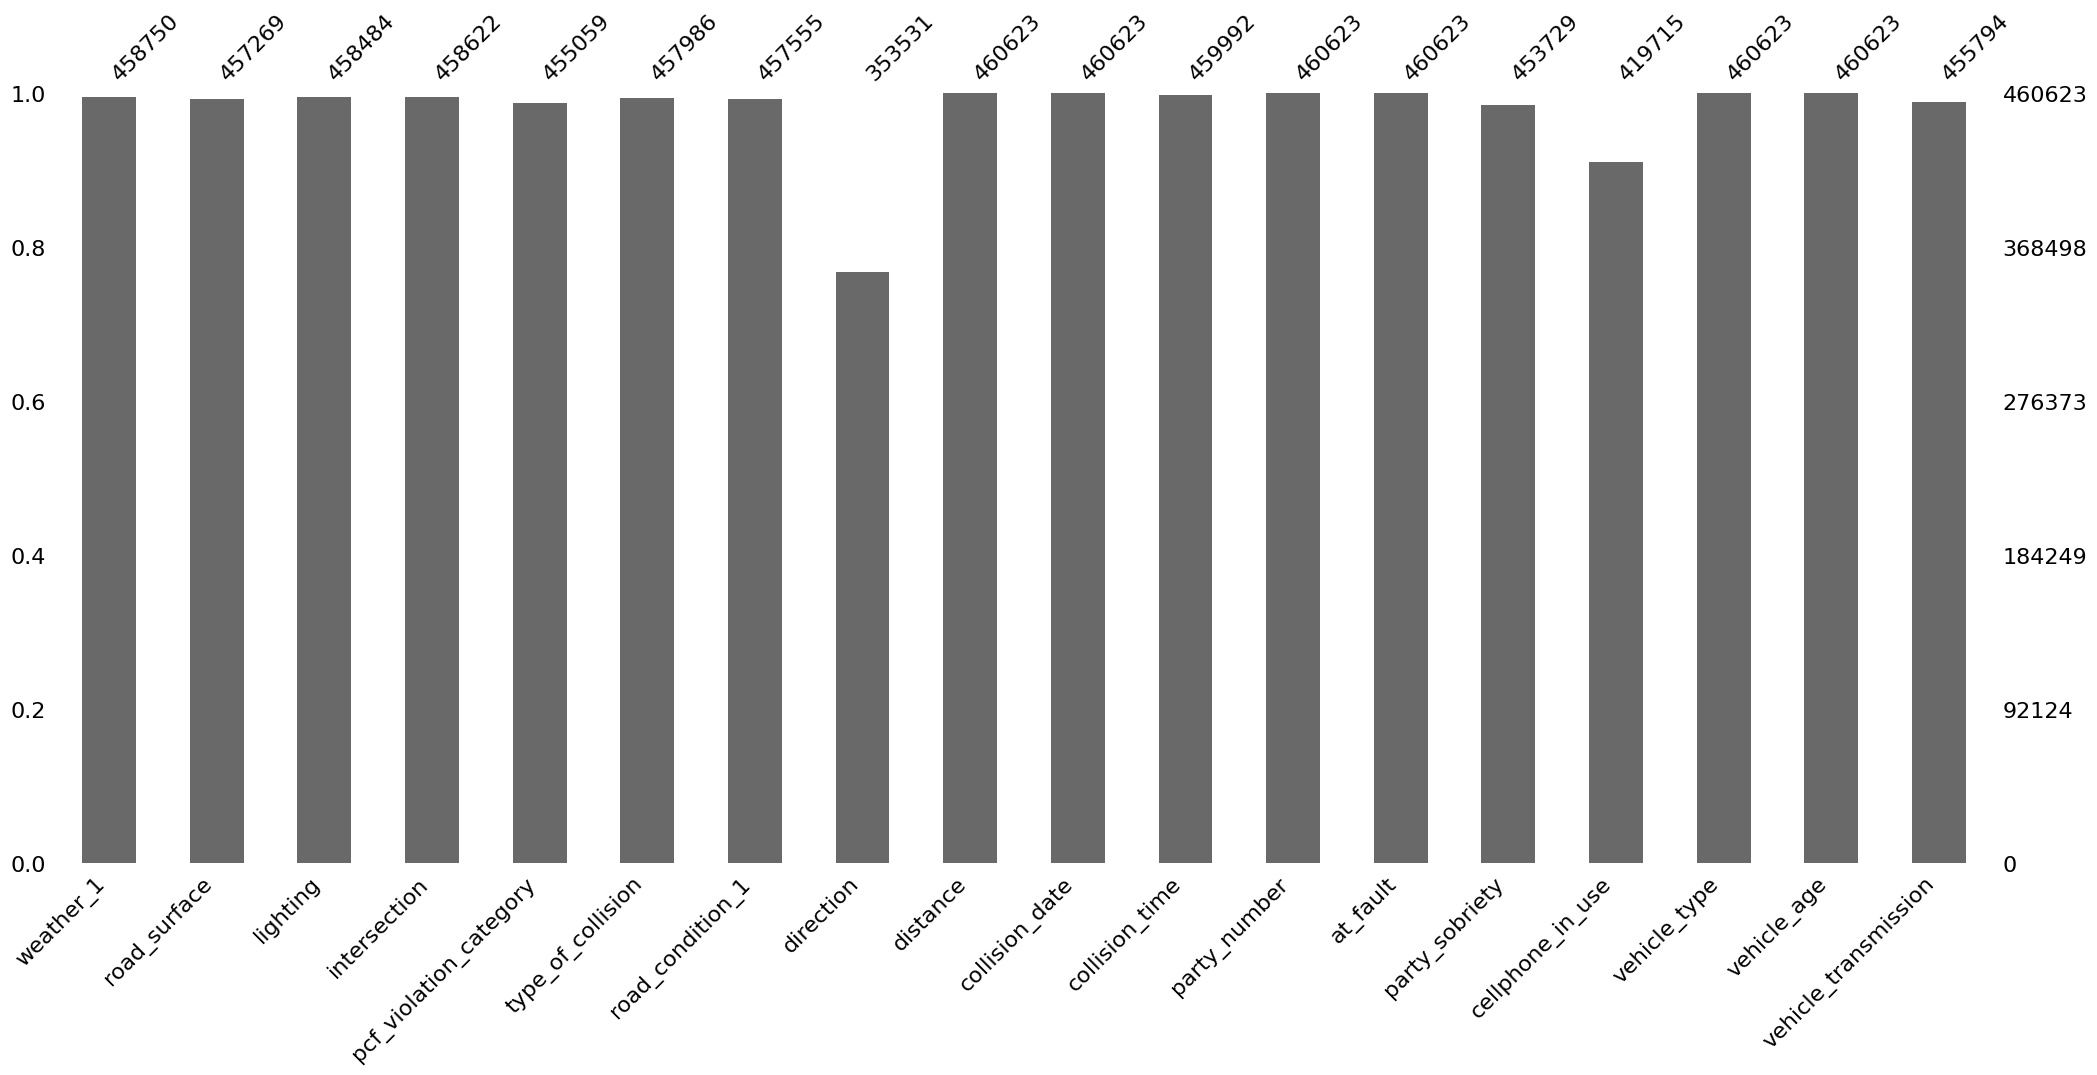

,count,mean,std,min,25%,50%,75%,max
intersection,458622.0,0.222320,0.415806,0.0,0.0,0.0,0.0,1.0
distance,460623.0,931.793401,25898.277504,0.0,7.0,126.0,528.0,8363520.0
party_number,460623.0,1.526546,0.663029,1.0,1.0,1.0,2.0,13.0
at_fault,460623.0,0.499719,0.500000,0.0,0.0,0.0,1.0,1.0
cellphone_in_use,419715.0,0.019211,0.137265,0.0,0.0,0.0,0.0,1.0
vehicle_age,460623.0,4.356843,2.592554,0.0,3.0,4.0,6.0,10.0


,weather_1,road_surface,lighting,intersection,pcf_violation_category,type_of_collision,road_condition_1,direction,distance,collision_date,collision_time,party_number,at_fault,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,vehicle_transmission
0,clear,dry,daylight,0.0,speeding,rear end,normal,north,199.0,2009-01-13,09:43:00,2,0,had not been drinking,0.0,sedan,3,manual
1,clear,dry,daylight,0.0,unsafe starting or backing,rear end,normal,south,27.0,2009-02-02,11:42:00,1,1,had not been drinking,0.0,sedan,4,auto
2,clear,dry,dark with street lights,0.0,improper turning,sideswipe,normal,west,66.0,2009-01-16,21:52:00,1,1,impairment unknown,0.0,sedan,2,auto
3,snowing,snowy,daylight,0.0,speeding,head-on,normal,east,3168.0,2009-02-15,11:50:00,3,0,had not been drinking,0.0,sedan,4,auto
4,clear,dry,daylight,0.0,speeding,rear end,normal,north,155.0,2009-03-14,17:59:00,1,1,None,NaN,sedan,2,manual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460618,clear,dry,daylight,0.0,unsafe lane change,hit object,normal,north,1584.0,2011-04-09,14:46:00,2,0,had not been drinking,0.0,sedan,3,manual
460619,clear,dry,dusk or dawn,0.0,speeding,rear end,normal,south,3600.0,2011-06-16,19:15:00,3,0,had not been drinking,0.0,sedan,6,auto
460620,clear,dry,dusk or dawn,1.0,improper turning,overturned,normal,None,0.0,2011-04-03,18:45:00,1,1,had not been drinking,0.0,coupe,2,manual
460621,clear,dry,daylight,0.0,unknown,sideswipe,normal,north,10.0,2011-06-03,10:25:00,2,0,had not been drinking,0.0,sedan,7,manual


In [13]:
check_data(df)

Пу-пу-пу....  
1) Первое что бросается в глаза - много пропусков, но сделать мы с ними ничего не можем, поэтому заполним их как unknown  
2) У нас в основном все признаки категориальные, ок, оценим их распределение на таргет  
3) Сгруппируем по месяцам, чтобы понять сезонность ДТП  

PS вначале посмотрим на результаты с такими данными, а потом попробуем удалить все пропуски и сравним результаты моделей

### детальные данные

Детальнее изучим каждый признак

In [14]:
logger.info("Все столбцы таблицы:")
logger.info(", ".join(df.columns))
logger.info("="*50)

exclude_columns = ['case_id', 'collision_date', 'collision_time', 'distance']  # для исключения

for col in df.columns:
    if col not in exclude_columns:
        display(f"{col}: ", end="")
        display(df[col].unique())

2025-11-26 22:16:51 [INFO] __main__: Все столбцы таблицы:
2025-11-26 22:16:51 [INFO] __main__: weather_1, road_surface, lighting, intersection, pcf_violation_category, type_of_collision, road_condition_1, direction, distance, collision_date, collision_time, party_number, at_fault, party_sobriety, cellphone_in_use, vehicle_type, vehicle_age, vehicle_transmission
2025-11-26 22:16:51 [INFO] __main__: ==================================================


'weather_1: '

array(['clear', 'snowing', 'cloudy', 'raining', 'fog', 'other', None,
       'wind'], dtype=object)

'road_surface: '

array(['dry', 'snowy', 'wet', None, 'slippery'], dtype=object)

'lighting: '

array(['daylight', 'dark with street lights',
       'dark with no street lights', 'dusk or dawn',
       'dark with street lights not functioning', None], dtype=object)

'intersection: '

array([ 0.,  1., nan])

'pcf_violation_category: '

array(['speeding', 'unsafe starting or backing', 'improper turning',
       'traffic signals and signs', 'automobile right of way', 'dui',
       'other hazardous violation', 'unknown', 'wrong side of road',
       'pedestrian violation', 'unsafe lane change', 'other equipment',
       'following too closely', 'improper passing',
       'other improper driving', None,
       'other than driver (or pedestrian)', 'hazardous parking',
       'impeding traffic', 'brakes', 'pedestrian right of way',
       'fell asleep', 'lights'], dtype=object)

'type_of_collision: '

array(['rear end', 'sideswipe', 'head-on', 'broadside', 'overturned',
       'hit object', 'other', None], dtype=object)

'road_condition_1: '

array(['normal', 'construction', 'obstruction', 'other', 'holes',
       'loose material', None, 'reduced width', 'flooded'], dtype=object)

'direction: '

array(['north', 'south', 'west', 'east', None], dtype=object)

'party_number: '

array([ 2,  1,  3,  4,  5,  6,  9,  7,  8, 13, 11, 10, 12])

'at_fault: '

array([0, 1])

'party_sobriety: '

array(['had not been drinking', 'impairment unknown', None,
       'had been drinking, not under influence',
       'had been drinking, under influence', 'not applicable',
       'had been drinking, impairment unknown'], dtype=object)

'cellphone_in_use: '

array([ 0., nan,  1.])

'vehicle_type: '

array(['sedan', 'coupe', 'other'], dtype=object)

'vehicle_age: '

array([ 3,  4,  2,  9,  8,  7,  0,  5,  6,  1, 10])

'vehicle_transmission: '

array(['manual', 'auto', None], dtype=object)

Есть пропуски в данных по многим признакам.  
Все категориальные пропуски заменить на unkwnown.  
Все числовые на -1.  
Но для начала визуаилизация данных

### посмотрим на выбросы

In [15]:
# здесь я хочу посмотреть только на дистанцию до главной дороги
# я честно не понимаю смысл этого признака
# что нам даст информация что дтп произошло в 100 км от главной дороги?!
# удалим пока все что дальше 10км, хотя я бы в принципе удалил все что дальше 1км исключительно с тобой логикой, что за это расстояние водитель уже должен был принять меры
# так и сделаем

df[df['distance'] > 1000]

,weather_1,road_surface,lighting,intersection,pcf_violation_category,type_of_collision,road_condition_1,direction,distance,collision_date,collision_time,party_number,at_fault,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,vehicle_transmission
3,snowing,snowy,daylight,0.0,speeding,head-on,normal,east,3168.0,2009-02-15,11:50:00,3,0,had not been drinking,0.0,sedan,4,auto
8,clear,dry,daylight,0.0,speeding,rear end,normal,north,1056.0,2009-05-18,07:45:00,2,0,had not been drinking,0.0,sedan,2,auto
9,clear,dry,daylight,0.0,improper turning,overturned,normal,west,11616.0,2009-07-06,07:15:00,1,1,had not been drinking,0.0,coupe,3,manual
14,clear,dry,daylight,0.0,other hazardous violation,sideswipe,normal,east,1056.0,2009-08-17,14:15:00,1,1,impairment unknown,0.0,sedan,3,auto
16,clear,dry,daylight,0.0,speeding,rear end,normal,south,1056.0,2009-08-19,14:55:00,2,0,impairment unknown,0.0,sedan,3,manual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460614,clear,dry,daylight,0.0,unsafe lane change,sideswipe,normal,west,1584.0,2012-01-15,13:30:00,2,0,had not been drinking,0.0,sedan,5,manual
460615,clear,dry,dark with no street lights,0.0,improper turning,overturned,normal,east,34320.0,2012-01-04,00:28:00,1,1,had not been drinking,0.0,sedan,0,auto
460616,clear,dry,dark with street lights,0.0,improper turning,sideswipe,normal,west,1320.0,2012-01-01,18:26:00,1,1,impairment unknown,NaN,sedan,5,auto
460618,clear,dry,daylight,0.0,unsafe lane change,hit object,normal,north,1584.0,2011-04-09,14:46:00,2,0,had not been drinking,0.0,sedan,3,manual


In [16]:
df = df[df['distance'] <= 1000]

### визуализация данных

2025-11-26 22:16:52 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-26 22:16:52 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-26 22:16:55 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-26 22:16:55 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-26 22:16:56 [INFO] matplotlib.category: 

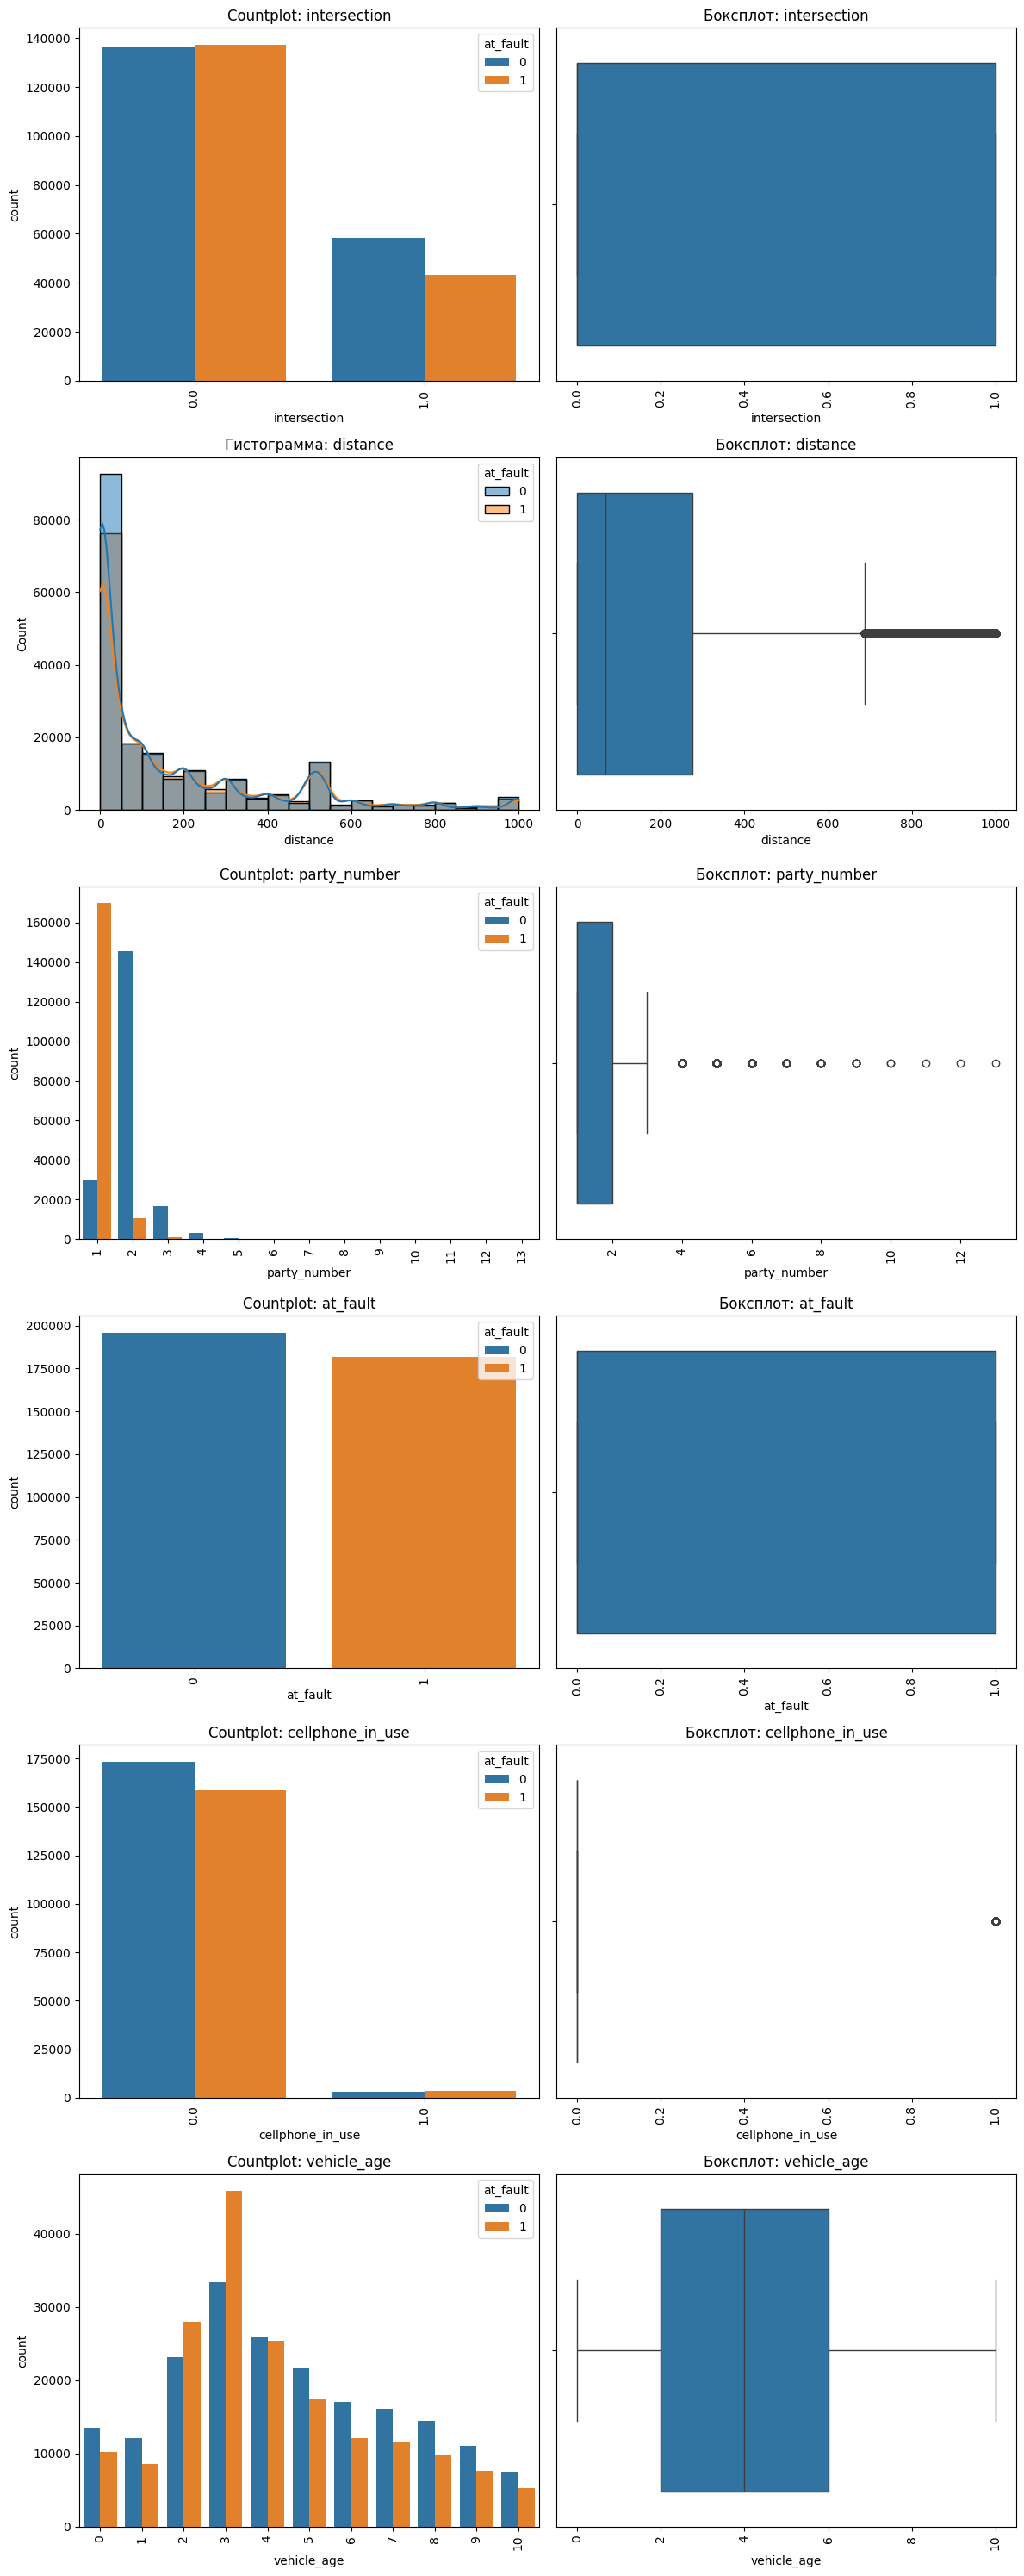

In [17]:
plot_combined(df, col=None, target='at_fault', col_type=None, legend_loc='best')

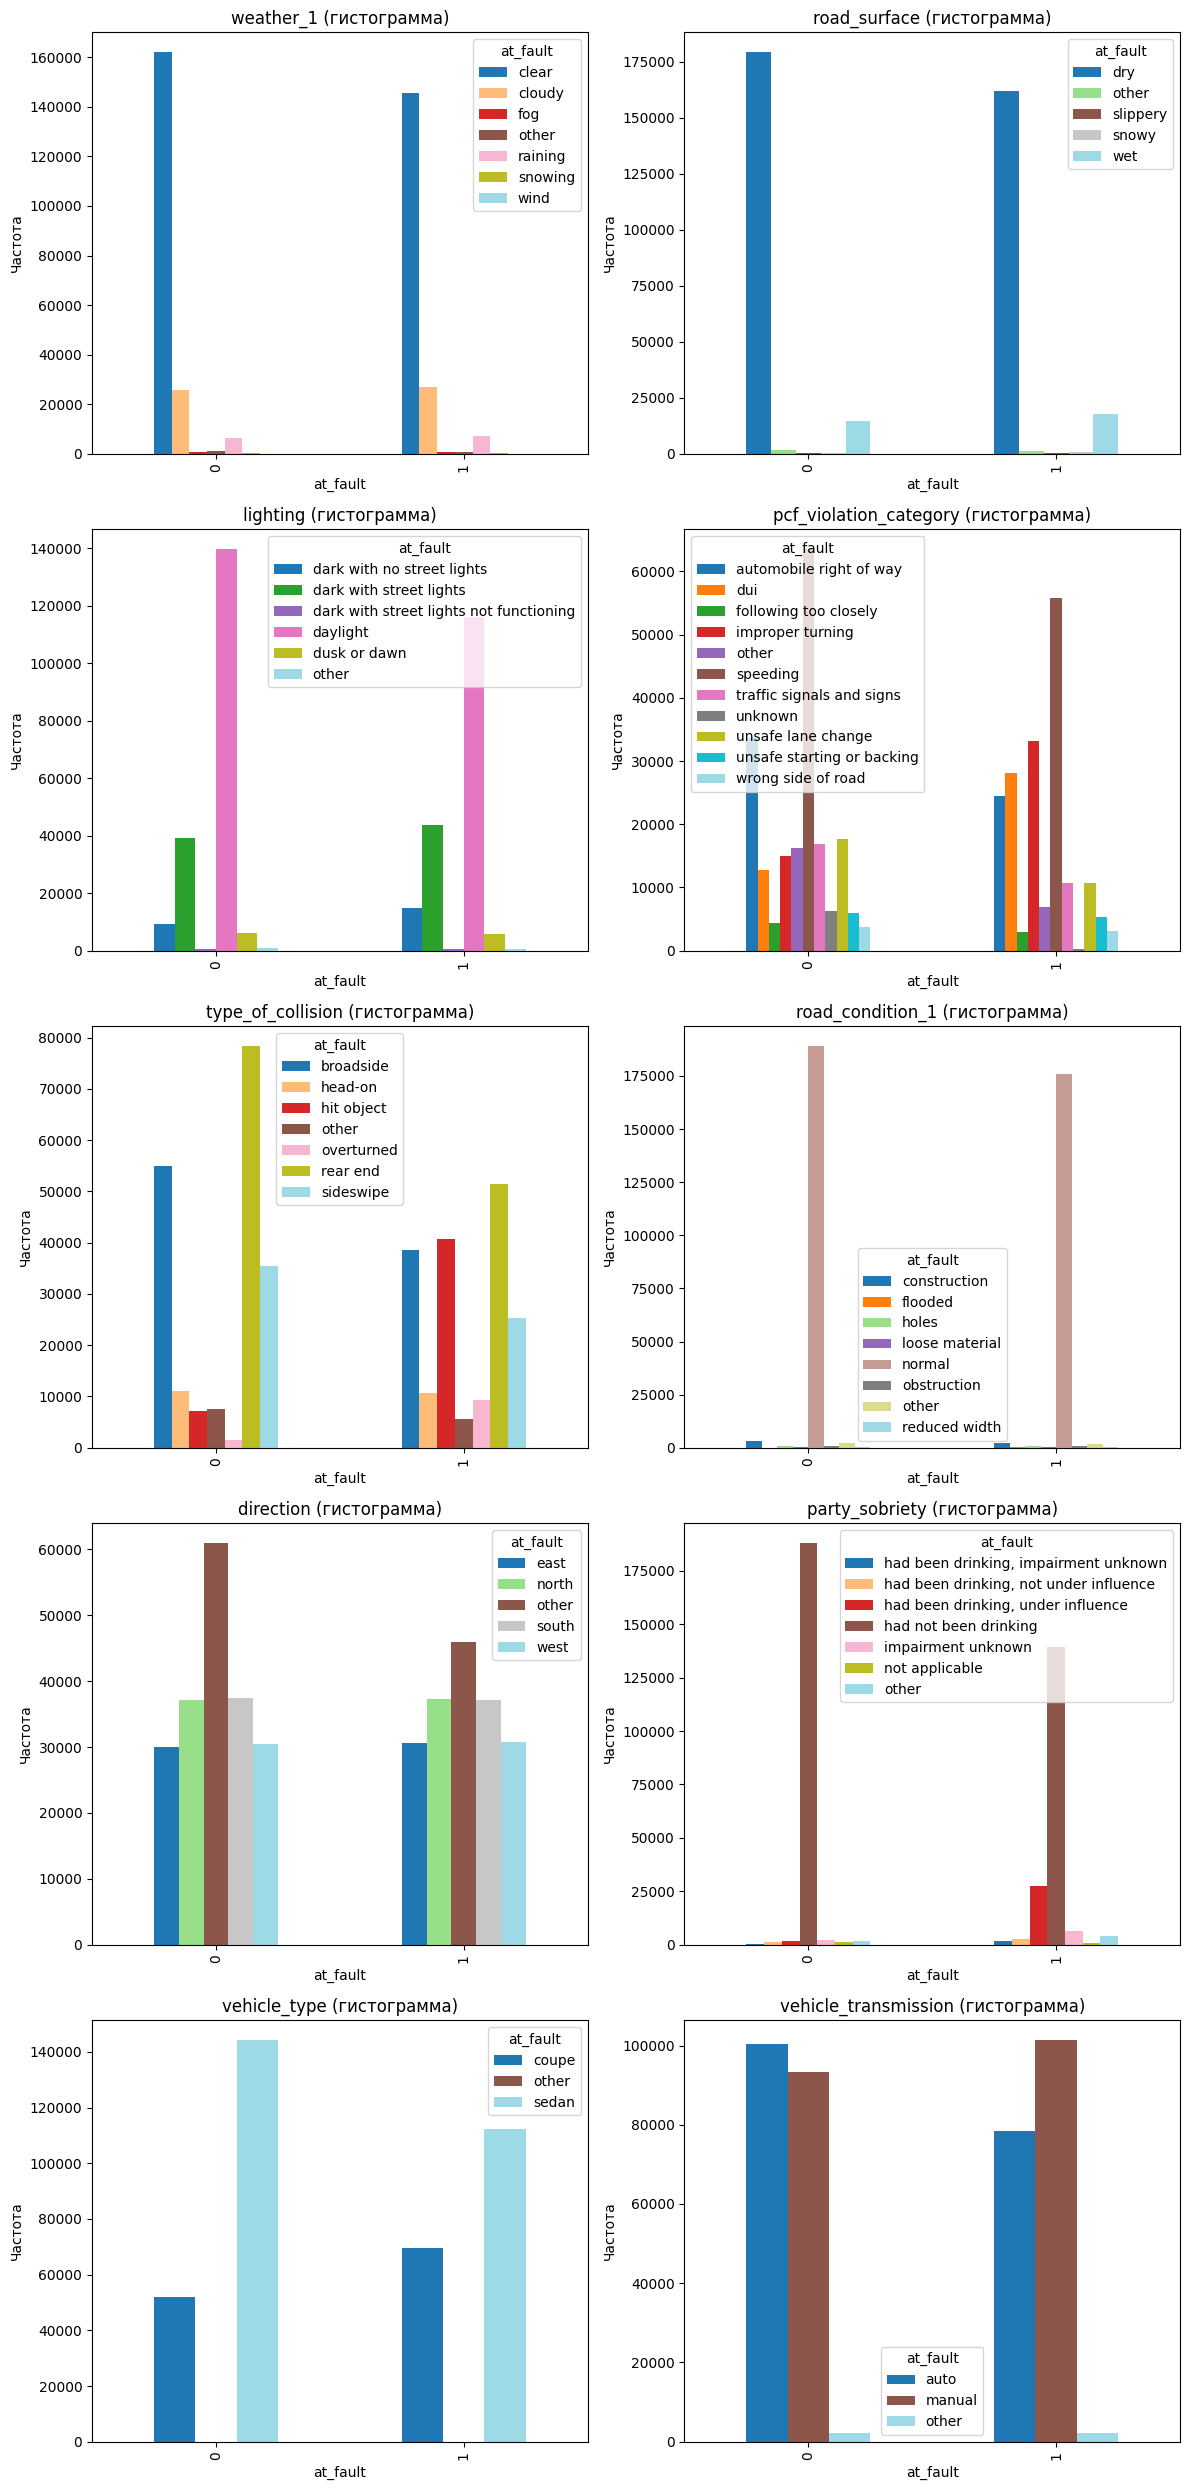

In [18]:
df_for_plot = df.drop(columns=['collision_date', 'collision_time'])
plot_categorical_columns(df_for_plot, col=None, target='at_fault', top_n=10)

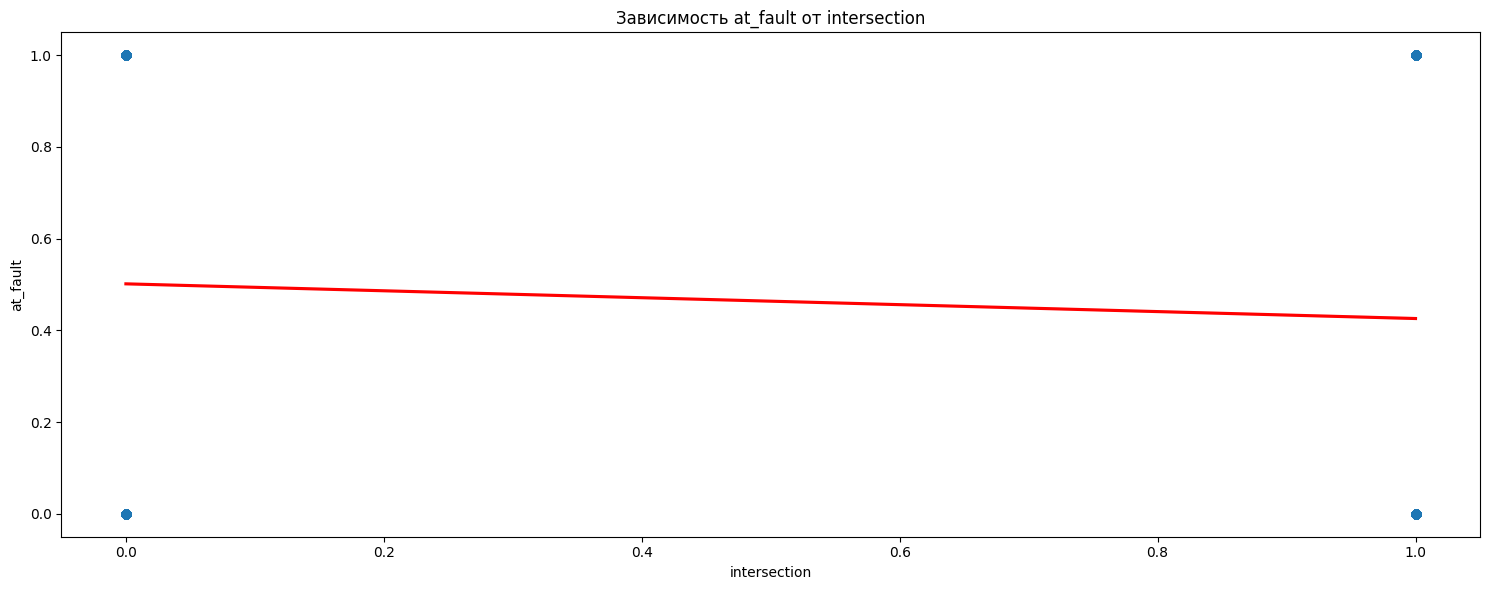

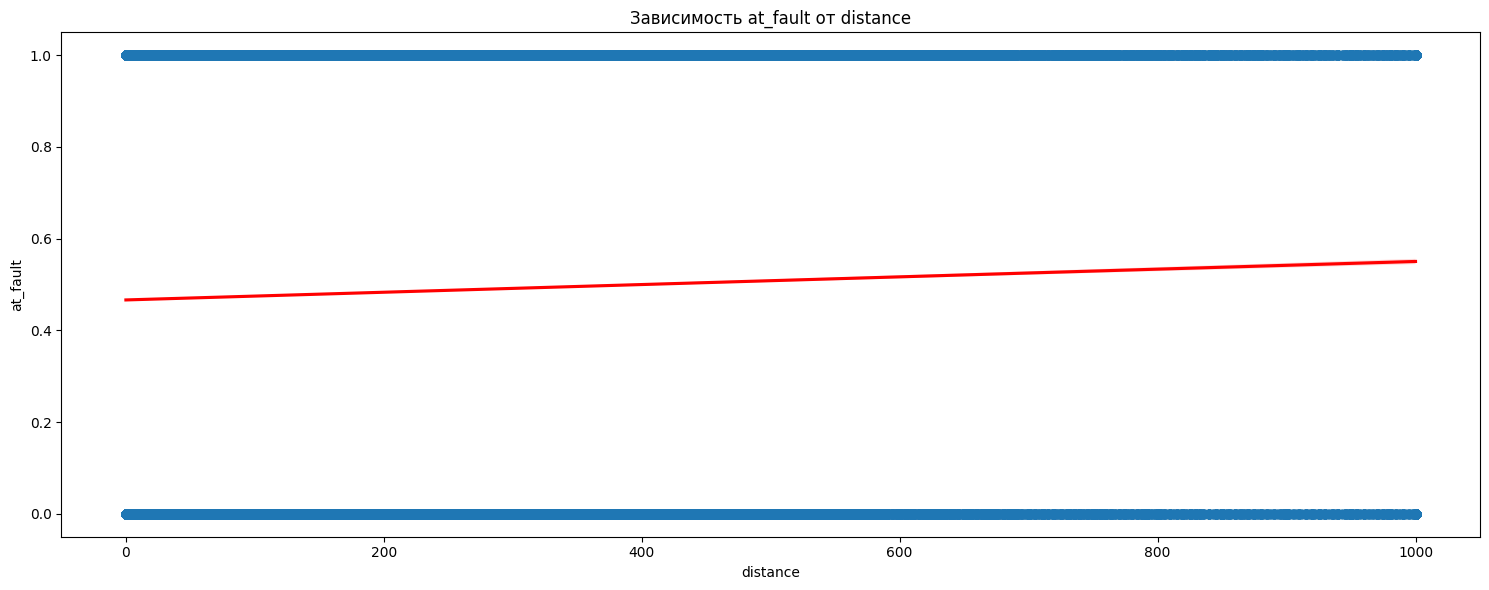

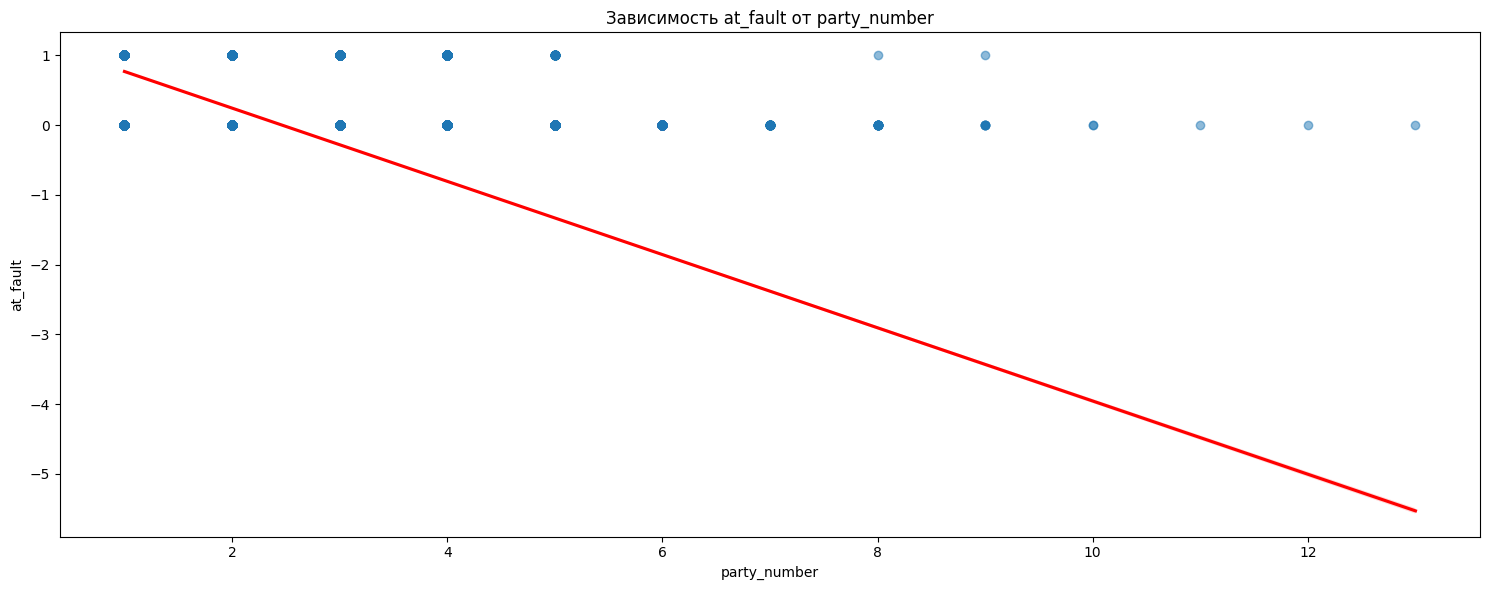

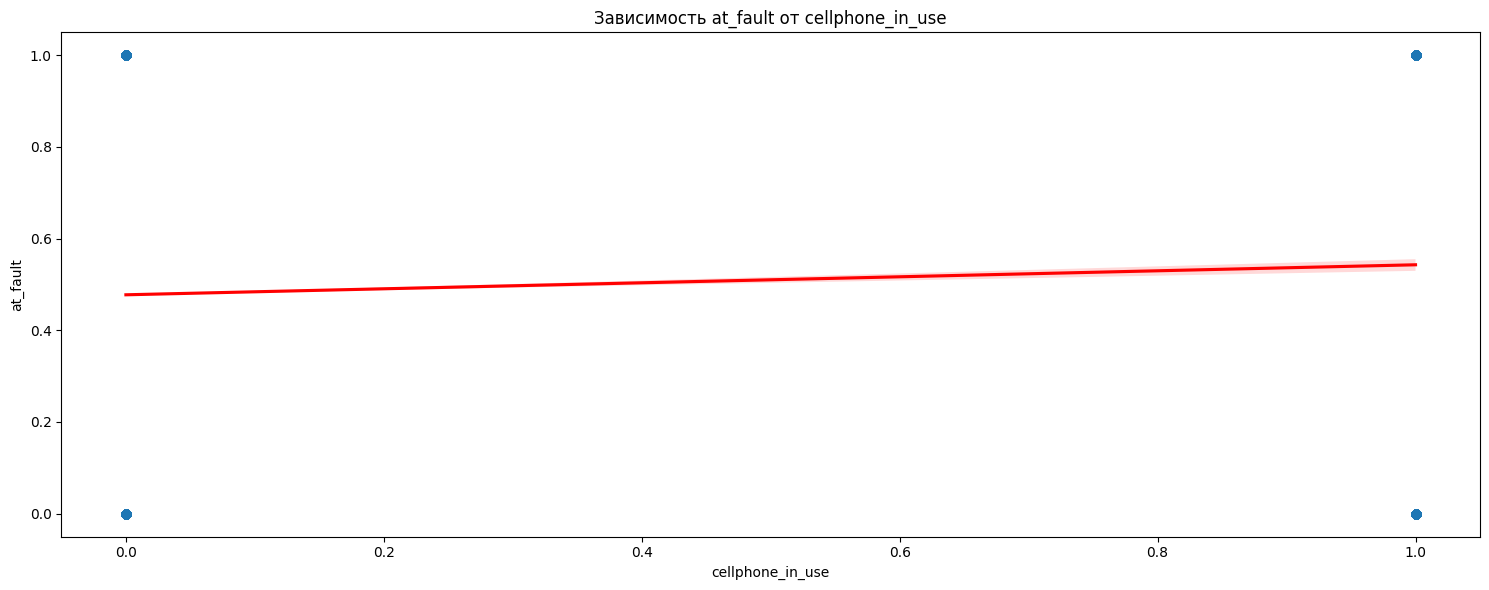

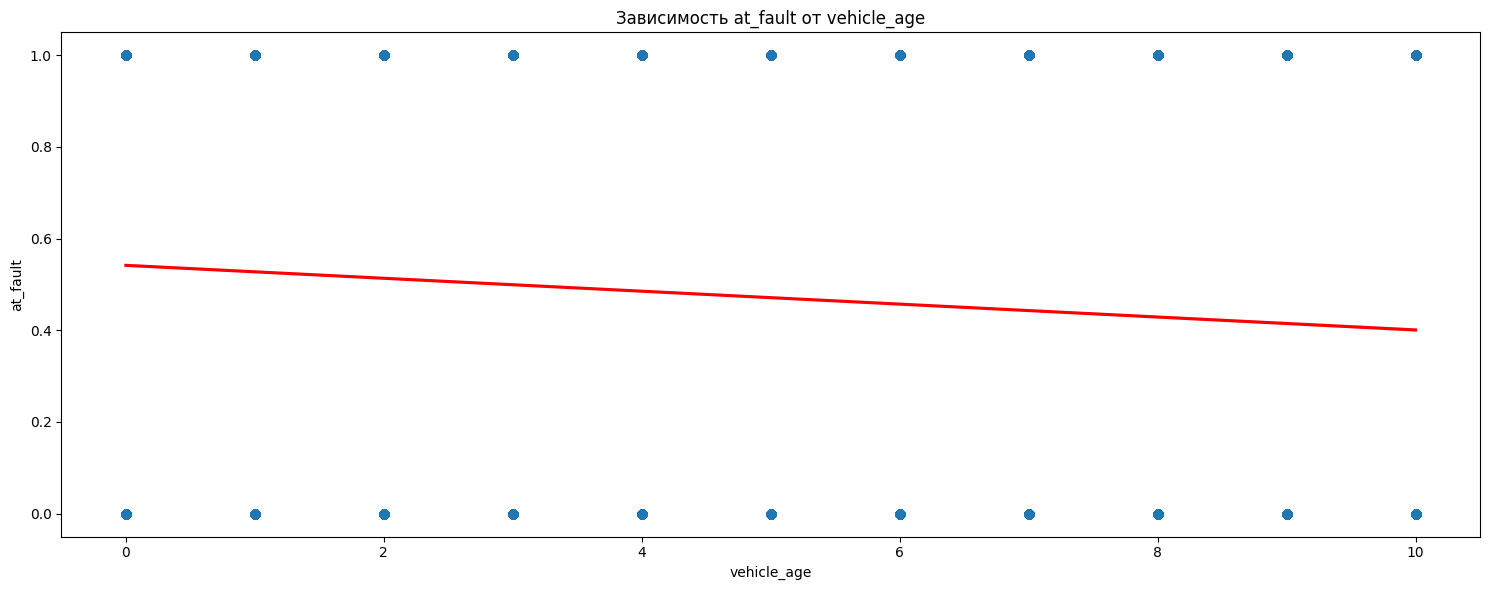

In [19]:
plot_scatter_with_numerical(df, target_column='at_fault')

### распределение по году

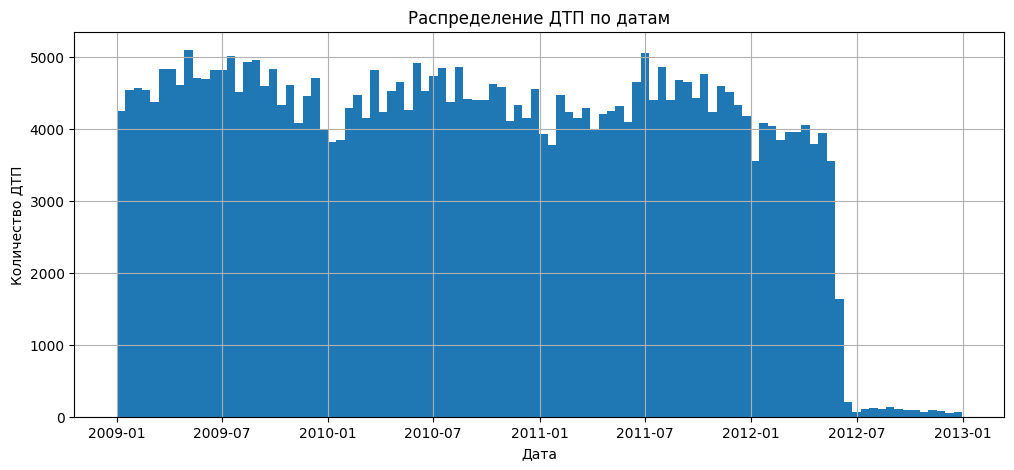

In [20]:
plt.figure(figsize=(12, 5))
df['collision_date'].hist(bins=100)
plt.title('Распределение ДТП по датам')
plt.xlabel('Дата')
plt.ylabel('Количество ДТП')
plt.show()

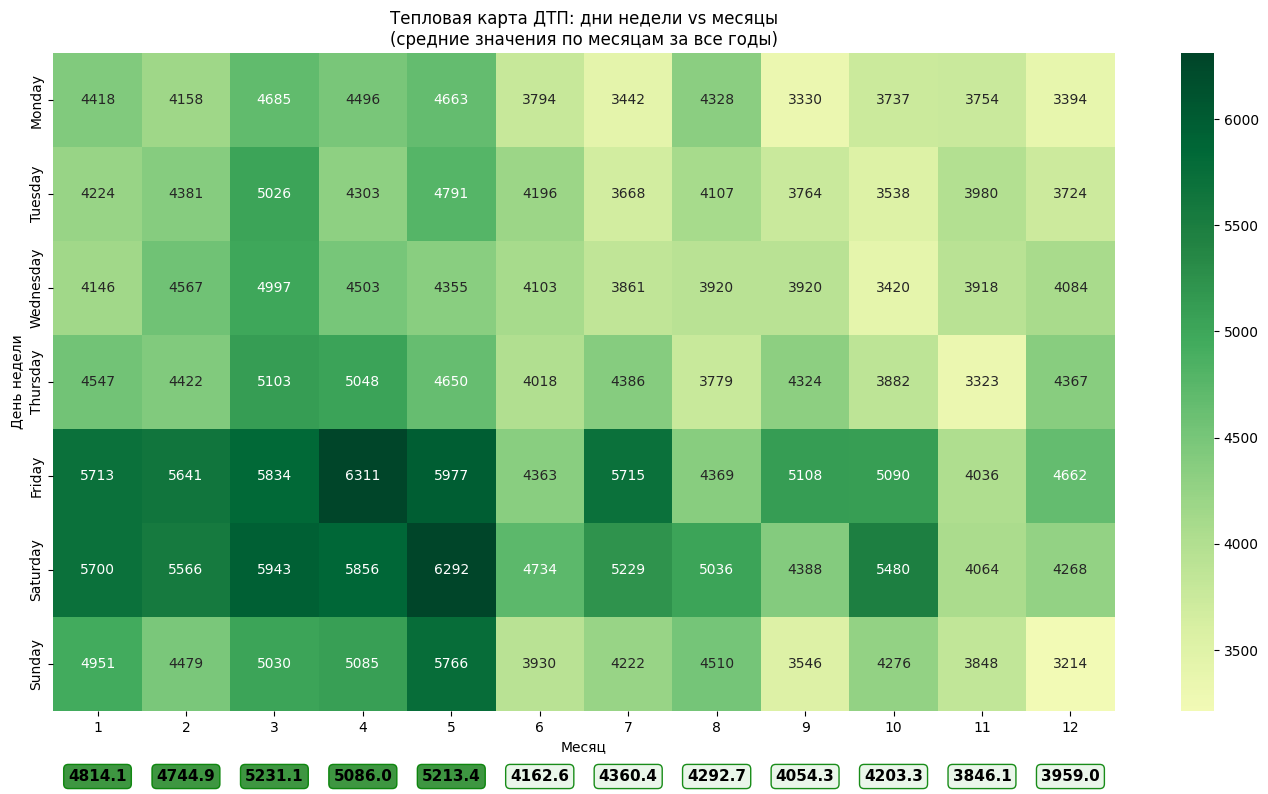

In [21]:
df['collision_date'] = pd.to_datetime(df['collision_date'])
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

pivot = df.groupby([df['collision_date'].dt.day_name(), df['collision_date'].dt.month]).size().unstack()
pivot = pivot.reindex(days_order)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGn', center=pivot.values.mean())

monthly_means = pivot.mean(axis=0)
mean_of_means = monthly_means.mean()

for i, (month, mean_val) in enumerate(monthly_means.items()):
    if mean_val < mean_of_means:
        # Более светлый зеленый для значений ниже среднего
        color = '#e8f5e8'
        text_color = "#000000"
    else:
        # Более насыщенный зеленый для значений выше среднего
        color = "#298b2c"
        text_color = "#000000"
    
    plt.text(i + 0.5, len(pivot) + 0.7, f'{mean_val:.1f}', 
             ha='center', va='center', fontweight='bold', fontsize=11,
             color=text_color,
             bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.9, edgecolor='green', linewidth=1))

plt.title('Тепловая карта ДТП: дни недели vs месяцы\n(средние значения по месяцам за все годы)')
plt.xlabel('Месяц')
plt.ylabel('День недели')
plt.tight_layout()
plt.show()

### распределение по времени

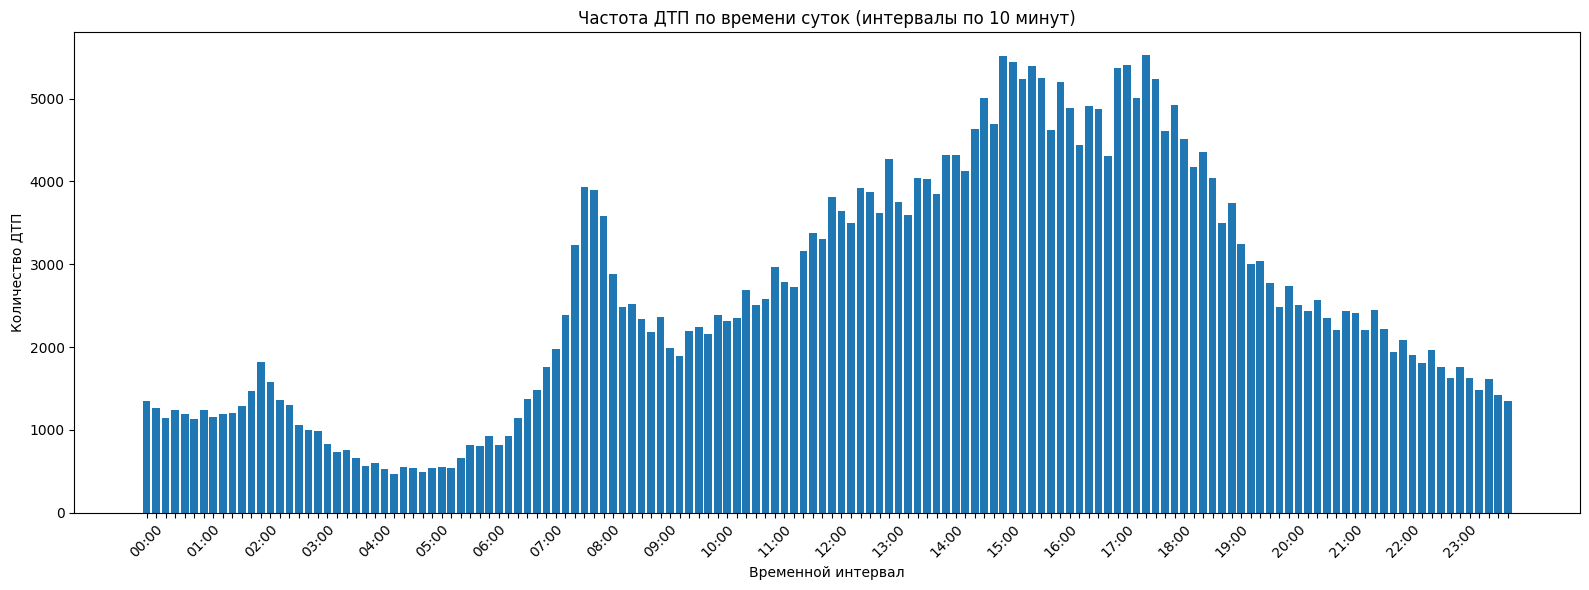

In [22]:
df_copy = df.copy()
df_copy['time_interval'] = pd.to_datetime(df_copy['collision_time'], format='%H:%M:%S').dt.floor('10min').dt.strftime('%H:%M')

plt.figure(figsize=(16, 6))
interval_counts = df_copy['time_interval'].value_counts().sort_index()

plt.bar(range(len(interval_counts)), interval_counts.values)
plt.title('Частота ДТП по времени суток (интервалы по 10 минут)')
plt.xlabel('Временной интервал')
plt.ylabel('Количество ДТП')

x_ticks = range(len(interval_counts))
x_labels = [label if i % 6 == 0 else '' for i, label in enumerate(interval_counts.index)]
plt.xticks(x_ticks, x_labels, rotation=45)

plt.tight_layout()
plt.show()

In [23]:
# создаем новые признаки из даты и времени
# сделаем месяц дтп и час дтп
df['month'] = pd.to_datetime(df['collision_date']).dt.month
df['hour'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S').dt.hour

In [24]:
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        df[col] = df[col].fillna('unknown')
    elif np.issubdtype(df[col].dtype, np.number):
        df[col] = df[col].fillna(-1)

In [25]:
# проверяем результат
drop_duplicated(df)
check_data(df)

np.int64(20)

'Удаляем'

<class 'pandas.core.frame.DataFrame'>
Index: 377776 entries, 0 to 460622
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   weather_1               377776 non-null  object        
 1   road_surface            377776 non-null  object        
 2   lighting                377776 non-null  object        
 3   intersection            377776 non-null  float64       
 4   pcf_violation_category  377776 non-null  object        
 5   type_of_collision       377776 non-null  object        
 6   road_condition_1        377776 non-null  object        
 7   direction               377776 non-null  object        
 8   distance                377776 non-null  float64       
 9   collision_date          377776 non-null  datetime64[ns]
 10  collision_time          377776 non-null  object        
 11  party_number            377776 non-null  int64         
 12  at_fault                377776 non-

None

,weather_1,road_surface,lighting,intersection,pcf_violation_category,type_of_collision,road_condition_1,direction,distance,collision_date,collision_time,party_number,at_fault,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,vehicle_transmission,month,hour
117016,clear,dry,daylight,1.0,automobile right of way,broadside,normal,unknown,0.0,2011-12-06,15:12:00,2,0,had not been drinking,0.0,sedan,9,auto,12,15.0
247285,clear,dry,dark with street lights,1.0,dui,rear end,normal,unknown,0.0,2011-07-29,23:20:00,2,0,had not been drinking,0.0,sedan,4,manual,7,23.0
304958,clear,dry,dusk or dawn,1.0,automobile right of way,broadside,normal,unknown,0.0,2009-01-16,17:15:00,1,1,had not been drinking,0.0,sedan,2,manual,1,17.0
50135,clear,dry,daylight,1.0,automobile right of way,broadside,normal,unknown,0.0,2010-06-10,15:20:00,2,0,had not been drinking,0.0,coupe,2,auto,6,15.0
110588,cloudy,dry,dark with street lights,0.0,speeding,head-on,normal,east,38.0,2009-08-22,20:24:00,1,1,had not been drinking,-1.0,sedan,4,manual,8,20.0


Series([], dtype: int64)

None

,count,mean,min,25%,50%,75%,max,std
intersection,377776.0,0.26476,-1.0,0.0,0.0,1.0,1.0,0.452678
distance,377776.0,176.634176,0.0,0.0,68.0,275.0,1000.0,236.463885
collision_date,377776,2010-09-04 19:06:41.685654784,2009-01-01 00:00:00,2009-10-22 00:00:00,2010-08-28 00:00:00,2011-07-14 00:00:00,2012-12-30 00:00:00,NaN
party_number,377776.0,1.545027,1.0,1.0,1.0,2.0,13.0,0.656327
at_fault,377776.0,0.481219,0.0,0.0,0.0,1.0,1.0,0.499648
cellphone_in_use,377776.0,-0.086808,-1.0,0.0,0.0,0.0,1.0,0.33736
vehicle_age,377776.0,4.289182,0.0,2.0,4.0,6.0,10.0,2.592086
month,377776.0,6.199703,1.0,3.0,6.0,9.0,12.0,3.418583
hour,377776.0,13.457684,-1.0,10.0,14.0,17.0,23.0,5.561272


,weather_1,road_surface,lighting,intersection,pcf_violation_category,type_of_collision,road_condition_1,direction,distance,collision_date,collision_time,party_number,at_fault,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,vehicle_transmission,month,hour
0,clear,dry,daylight,0.0,speeding,rear end,normal,north,199.0,2009-01-13,09:43:00,2,0,had not been drinking,0.0,sedan,3,manual,1,9.0
1,clear,dry,daylight,0.0,unsafe starting or backing,rear end,normal,south,27.0,2009-02-02,11:42:00,1,1,had not been drinking,0.0,sedan,4,auto,2,11.0
2,clear,dry,dark with street lights,0.0,improper turning,sideswipe,normal,west,66.0,2009-01-16,21:52:00,1,1,impairment unknown,0.0,sedan,2,auto,1,21.0
4,clear,dry,daylight,0.0,speeding,rear end,normal,north,155.0,2009-03-14,17:59:00,1,1,unknown,-1.0,sedan,2,manual,3,17.0
5,clear,dry,daylight,1.0,traffic signals and signs,broadside,normal,unknown,0.0,2009-02-27,13:35:00,2,0,"had been drinking, not under influence",0.0,sedan,9,manual,2,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460613,clear,dry,dark with street lights,0.0,improper turning,head-on,normal,west,908.0,2012-01-13,21:43:00,1,1,had not been drinking,0.0,sedan,3,manual,1,21.0
460617,clear,dry,daylight,1.0,automobile right of way,broadside,normal,unknown,0.0,2011-05-03,08:00:00,1,1,had not been drinking,-1.0,sedan,5,manual,5,8.0
460620,clear,dry,dusk or dawn,1.0,improper turning,overturned,normal,unknown,0.0,2011-04-03,18:45:00,1,1,had not been drinking,0.0,coupe,2,manual,4,18.0
460621,clear,dry,daylight,0.0,unknown,sideswipe,normal,north,10.0,2011-06-03,10:25:00,2,0,had not been drinking,0.0,sedan,7,manual,6,10.0


### кореляция с таргетом

'=== Корреляция с таргетом ==='

party_number             -0.689368
vehicle_type             -0.126351
pcf_violation_category   -0.108565
party_sobriety           -0.108484
lighting                 -0.087111
hour                     -0.082801
vehicle_transmission      0.078491
vehicle_age              -0.073108
intersection             -0.067114
type_of_collision        -0.064446
road_surface              0.040174
distance                  0.039712
direction                -0.028358
weather_1                 0.025361
cellphone_in_use         -0.006987
month                    -0.005568
road_condition_1         -0.001663
Name: at_fault, dtype: float64

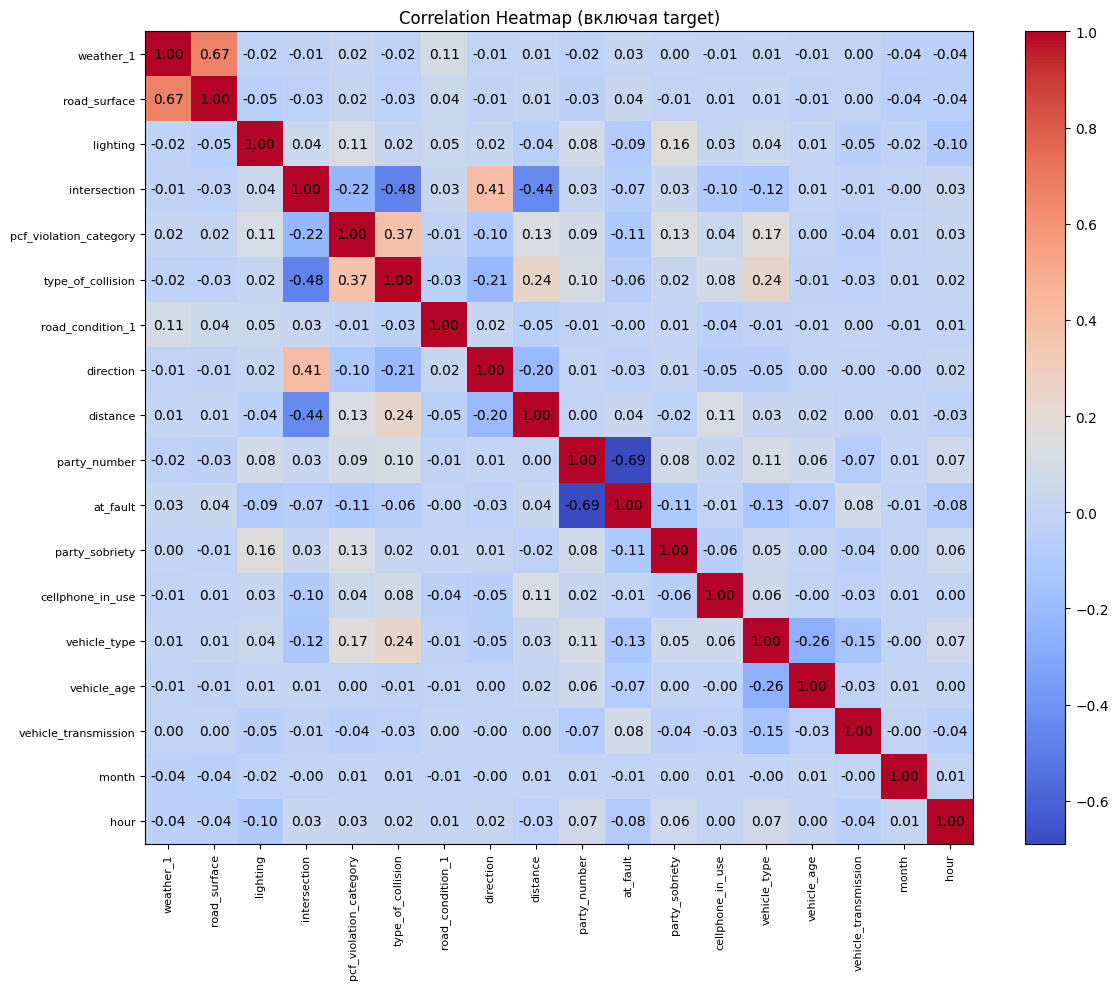

'=== VIF ==='

,feature,VIF
5,type_of_collision,2.288284
3,intersection,2.194569
0,weather_1,2.047994
1,road_surface,2.010446
4,pcf_violation_category,1.724396
12,vehicle_type,1.617378
14,vehicle_transmission,1.504652
9,party_number,1.455353
8,distance,1.338577
2,lighting,1.312948


In [26]:
df_cor = df.drop(columns=['collision_date', 'collision_time'])
calc_target_correlations(df_cor, target_col="at_fault")

# Обучение модели

In [27]:
# для модели нам нужен только 2012 год
df = df[df['collision_date'].between('2012-01-01', '2012-12-31')]

In [28]:
# уберем утечки и лишние данные
columns_to_drop = [
    'party_sobriety',
    'pcf_violation_category', 
    'type_of_collision',
    'collision_date',
    'collision_time'
]

df = df.drop(columns=columns_to_drop)

In [29]:
# возьмем часть данных для подбора гиперпараметров и финального теста
df_rest, df_test = train_test_split(
    df, 
    test_size=0.05, 
    stratify=df['at_fault'], 
    random_state=RANDOM_STATE
)

logger.info("Распределение таргета:")
logger.info(f"Тест: {df_test['at_fault'].value_counts(normalize=True)}")
logger.info(f"Остальные: {df_rest['at_fault'].value_counts(normalize=True)}")

2025-11-26 22:19:07 [INFO] __main__: Распределение таргета:
2025-11-26 22:19:07 [INFO] __main__: Тест: at_fault
0    0.512673
1    0.487327
Name: proportion, dtype: float64
2025-11-26 22:19:07 [INFO] __main__: Остальные: at_fault
0    0.512689
1    0.487311
Name: proportion, dtype: float64


In [30]:
# разделим на выборки их оставшихся данных
X_train, X_val, y_train, y_val = train_test_split(
    df_rest.drop(['at_fault'], axis=1),
    df_rest['at_fault'],
    test_size=TEST_SIZE,
    stratify=df_rest['at_fault'],
    random_state=RANDOM_STATE
)

# финальный отложенный тест
X_final_test = df_test.drop(['at_fault'], axis=1)
y_final_test = df_test['at_fault']

logger.info(f"Размеры выборок: Train={X_train.shape}, Val={X_val.shape}, Test={X_final_test.shape}")
logger.info(f"Распределение таргета - Train: {y_train.value_counts(normalize=True).to_dict()}")

2025-11-26 22:19:07 [INFO] __main__: Размеры выборок: Train=(31774, 14), Val=(7944, 14), Test=(2091, 14)
2025-11-26 22:19:07 [INFO] __main__: Распределение таргета - Train: {0: 0.5126833259898029, 1: 0.487316674010197}


In [31]:
# сюда будем писать результаты
results = {}

In [32]:
# разделяем признаки
# для ordinal ничего подходящего у нас нет
cat_selector = make_column_selector(dtype_include=["object", "category", "bool"])
num_selector = make_column_selector(dtype_exclude=["object", "category", "bool"])

# циклические признаки
cyclic_cols = ['month', 'hour']

In [33]:
cat_cols = cat_selector(X_train)
num_cols = num_selector(X_train)

# убираем циклические признаки из числовых, если они там есть
num_cols = [col for col in num_cols if col not in cyclic_cols]

cyclic_cols = [col for col in ['month', 'hour'] if col in X_train.columns]
if not cyclic_cols:
    logger.warning("Циклические признаки 'month' и 'hour' не найдены в данных")

display("Категориальные:", cat_cols)
display("Числовые:", num_cols)
display("Циклические:", cyclic_cols)
logger.info(f"Всего: {len(cat_cols)} категориальных, {len(num_cols)} числовых, {len(cyclic_cols)} циклических")

'Категориальные:'

['weather_1',
 'road_surface',
 'lighting',
 'road_condition_1',
 'direction',
 'vehicle_type',
 'vehicle_transmission']

'Числовые:'

['intersection', 'distance', 'party_number', 'cellphone_in_use', 'vehicle_age']

'Циклические:'

['month', 'hour']

2025-11-26 22:19:07 [INFO] __main__: Всего: 7 категориальных, 5 числовых, 2 циклических


In [34]:
to_str = FunctionTransformer(lambda x: x.astype(str))

In [35]:
def create_cyclic_features(X):
    """Создает циклические признаки для month и hour"""
    X_cyclic = X.copy()
    
    if 'month' in X.columns:
        X_cyclic['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
        X_cyclic['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    
    if 'hour' in X.columns:
        X_cyclic['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
        X_cyclic['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
    
    return X_cyclic.drop(columns=['month', 'hour'], errors='ignore')

cyclic_transformer = FunctionTransformer(create_cyclic_features)

In [36]:
# Для линейных моделей
preprocessor_linear = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cyclic", Pipeline([
            ("cyclic", cyclic_transformer),
            ("scaler", StandardScaler())
        ]), cyclic_cols),
        ("cat", Pipeline([
            ("to_str", to_str),
            ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))
        ]), cat_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Для деревьев и бустингов  
preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cyclic", cyclic_transformer, cyclic_cols),
        ("cat", Pipeline([
            ("to_str", to_str),
            ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), cat_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

In [37]:
models = {
    "LogisticRegression": (lambda: LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight="balanced"), preprocessor_linear),
    "DecisionTree": (lambda: DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"), preprocessor_tree),
    "RandomForest": (lambda: RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, class_weight="balanced"), preprocessor_tree),
    "LightGBM": (lambda: LGBMClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, verbosity=-1), preprocessor_tree),
    "XGBoost": (lambda: XGBClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, verbosity=0, use_label_encoder=False), preprocessor_tree)
}

In [38]:
param_grid = {
    "LogisticRegression": {
        "C": (0.001, 10, "log")
    },
    "RandomForest": {
        "n_estimators": (100, 1000, 100),
        "max_depth": (3, 1500),
        "min_samples_split": (2, 15),
        "min_samples_leaf": (1, 5),
        "max_features": ["sqrt", "log2"]
    },
    "DecisionTree": {
        "max_depth": (3, 40),
        "min_samples_split": (2, 15),
        "min_samples_leaf": (1, 5),
        "max_features": ["sqrt", "log2"]
    },
    "LightGBM": {
        "n_estimators": (100, 1000, 100),
        "max_depth": (3, 40),
        "learning_rate": (0.01, 0.3, "log"),
        "num_leaves": (20, 128),
        "min_child_samples": (10, 60)
    },
    "XGBoost": {
        "n_estimators": (100, 1000, 100),
        "max_depth": (3, 40),
        "learning_rate": (0.01, 0.3, "log"),
        "subsample": (0.5, 1.0),
        "colsample_bytree": (0.5, 1.0)
    }
}

In [39]:
def objective_model(trial, model_name, preprocessor):
    # SelectKBest с ограничением
    k_max = min(100, X_train.shape[1])
    k_best = trial.suggest_int("selectkbest__k", 1, k_max)

    # Настройка модели
    pgrid = param_grid[model_name]

    if model_name == "LogisticRegression":
        C = suggest_param(trial, "C", pgrid["C"])
        model = LogisticRegression(
            C=C,
            random_state=RANDOM_STATE,
            max_iter=1000,
            class_weight="balanced"
        )

    elif model_name in ["RandomForest", "DecisionTree"]:
        cls = RandomForestClassifier if model_name == "RandomForest" else DecisionTreeClassifier
        model_params = {}
        for key, spec in pgrid.items():
            model_params[key] = suggest_param(trial, key, spec)
        model_params["random_state"] = RANDOM_STATE
        if model_name == "RandomForest":
            model_params["n_jobs"] = N_JOBS
        model_params["class_weight"] = "balanced"
        model = cls(**model_params)

    elif model_name == "LightGBM":
        model_params = {}
        for key, spec in pgrid.items():
            model_params[key] = suggest_param(trial, key, spec)
        model_params["random_state"] = RANDOM_STATE
        model_params["n_jobs"] = N_JOBS
        model_params["verbosity"] = -1
        model_params["class_weight"] = "balanced"
        model = LGBMClassifier(**model_params)

    elif model_name == "XGBoost":
        model_params = {}
        for key, spec in pgrid.items():
            model_params[key] = suggest_param(trial, key, spec)
        model_params["random_state"] = RANDOM_STATE
        model_params["n_jobs"] = N_JOBS
        model_params["verbosity"] = 0
        model_params["use_label_encoder"] = False
        scale_pos_weight = (y_train == 0).sum() / max(1, (y_train == 1).sum())
        model_params["scale_pos_weight"] = scale_pos_weight
        model = XGBClassifier(**model_params)

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("selectkbest", SelectKBest(score_func=f_classif, k=k_best)),
        ("classifier", model)
    ])

    # Обучаем на X_train, валидируем на X_val
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)

    f1 = f1_score(y_val, y_pred)

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return f1

## Подбор лучшей модели

In [40]:
best_models = {}
study_results = []

early_stop_cb = EarlyStoppingCallback(patience=EARLY_STOP)

def log_every_N_trials(study, trial, N=100):
    if trial.number % N == 0:
        best_trial = study.best_trial
        logger.info(
            f"[Trial {trial.number} finished]. Trial {best_trial.number} is best: F1={best_trial.value:.4f}, params={best_trial.params}"
        )

# Отключаем логи Optuna чтобы избежать дублирования
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

for model_name, (model_factory, preprocessor) in models.items():
    logger.info(f"\n\n=== Optimizing {model_name} ===")

    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0)
    study = optuna.create_study(direction="maximize", pruner=pruner)

    study.optimize(
        lambda trial: objective_model(trial, model_name, preprocessor),
        n_trials=N_ITER,
        callbacks=[log_every_N_trials, early_stop_cb]
    )

    best_params = study.best_params
    best_value = study.best_value
    logger.info(f"Best trial {study.best_trial.number} -> F1={best_value:.4f}, params={best_params}")

    # Создаем финальный пайплайн
    k_best_final = best_params.get("selectkbest__k", X_train.shape[1])
    final_pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("selectkbest", SelectKBest(score_func=f_classif, k=k_best_final)),
        ("classifier", model_factory())
    ])

    # Правильно устанавливаем параметры с префиксами
    pipeline_params = {}
    for param_name, param_value in best_params.items():
        # Добавляем префикс 'classifier__' для параметров модели
        if param_name not in ['selectkbest__k'] and not param_name.startswith('classifier__'):
            pipeline_params[f"classifier__{param_name}"] = param_value
        else:
            pipeline_params[param_name] = param_value

    # Устанавливаем параметры
    final_pipe.set_params(**pipeline_params)
    
    # Обучаем на всех тренировочных данных
    final_pipe.fit(X_train, y_train)
    best_models[model_name] = final_pipe

    study_results.append({
        "Model": model_name,
        "Best_params": best_params,
        "F1_CV": best_value
    })

2025-11-26 22:19:07 [INFO] __main__: 

=== Optimizing LogisticRegression ===
2025-11-26 22:19:08 [INFO] __main__: [Trial 0 finished]. Trial 0 is best: F1=0.8960, params={'selectkbest__k': 9, 'C': 2.0427772275931235}
2025-11-26 22:19:15 [INFO] func: Ранняя остановка: нет улучшений 50 trials
2025-11-26 22:19:15 [INFO] __main__: Best trial 0 -> F1=0.8960, params={'selectkbest__k': 9, 'C': 2.0427772275931235}
2025-11-26 22:19:15 [INFO] __main__: 

=== Optimizing DecisionTree ===
2025-11-26 22:19:15 [INFO] __main__: [Trial 0 finished]. Trial 0 is best: F1=0.8936, params={'selectkbest__k': 10, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}
2025-11-26 22:19:15 [INFO] func: Ранняя остановка: нет улучшений 50 trials
2025-11-26 22:19:15 [INFO] __main__: Best trial 0 -> F1=0.8936, params={'selectkbest__k': 10, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}
2025-11-26 22:19:15 [INFO] __main__: 

=== Optimizing Random

## Сравнение результатов

In [41]:
for res in study_results:
    name = res["Model"]
    model = best_models[name]

    # Предсказания вероятностей
    y_val_pred = model.predict_proba(X_val)[:, 1]
    y_test_pred = model.predict_proba(X_final_test)[:, 1]

    # Бинарные предсказания (порог 0.5)
    y_val_bin = (y_val_pred >= 0.5).astype(int)
    y_test_bin = (y_test_pred >= 0.5).astype(int)

    # ROC-AUC
    res["ROC_AUC_Val"] = roc_auc_score(y_val, y_val_pred)
    res["ROC_AUC_FinalTest"] = roc_auc_score(y_final_test, y_test_pred)
    
    # F1 Score
    res["F1_Val"] = f1_score(y_val, y_val_bin)
    res["F1_FinalTest"] = f1_score(y_final_test, y_test_bin)
    
    # Accuracy
    res["Accuracy_Val"] = accuracy_score(y_val, y_val_bin)
    res["Accuracy_FinalTest"] = accuracy_score(y_final_test, y_test_bin)

    # Confusion Matrix
    # cm = confusion_matrix(y_final_test, y_test_bin)
    # cm_df = pd.DataFrame(
    #     cm,
    #     index=["0", "1"],
    #     columns=["0", "1"]
    # )

    logger.info(f"=== {name} ===")
    # display(cm_df.style.set_caption("Confusion Matrix"))
    logger.info(f"F1 Score: {res['F1_FinalTest']:.4f}")
    logger.info("-" * 50)

# Сводная таблица по F1 Score (основная метрика)
results_df = pd.DataFrame(study_results)
display(results_df.sort_values("F1_FinalTest", ascending=False))

2025-11-26 22:19:25 [INFO] __main__: === LogisticRegression ===
2025-11-26 22:19:25 [INFO] __main__: F1 Score: 0.8991
2025-11-26 22:19:25 [INFO] __main__: --------------------------------------------------
2025-11-26 22:19:25 [INFO] __main__: === DecisionTree ===
2025-11-26 22:19:25 [INFO] __main__: F1 Score: 0.8973
2025-11-26 22:19:25 [INFO] __main__: --------------------------------------------------
2025-11-26 22:19:26 [INFO] __main__: === RandomForest ===
2025-11-26 22:19:26 [INFO] __main__: F1 Score: 0.8991
2025-11-26 22:19:26 [INFO] __main__: --------------------------------------------------
2025-11-26 22:19:26 [INFO] __main__: === LightGBM ===
2025-11-26 22:19:26 [INFO] __main__: F1 Score: 0.8792
2025-11-26 22:19:26 [INFO] __main__: --------------------------------------------------
2025-11-26 22:19:26 [INFO] __main__: === XGBoost ===
2025-11-26 22:19:26 [INFO] __main__: F1 Score: 0.0000
2025-11-26 22:19:26 [INFO] __main__: --------------------------------------------------


,Model,Best_params,F1_CV,ROC_AUC_Val,ROC_AUC_FinalTest,F1_Val,F1_FinalTest,Accuracy_Val,Accuracy_FinalTest
0,LogisticRegression,"{'selectkbest__k': 9, 'C': 2.0427772275931235}",0.896038,0.910892,0.910006,0.896038,0.899057,0.894637,0.897657
2,RandomForest,"{'selectkbest__k': 3, 'n_estimators': 900, 'ma...",0.896038,0.906575,0.908968,0.896038,0.899057,0.894637,0.897657
1,DecisionTree,"{'selectkbest__k': 10, 'max_depth': 35, 'min_s...",0.893564,0.909561,0.910526,0.893564,0.897302,0.892372,0.896222
3,LightGBM,"{'selectkbest__k': 12, 'n_estimators': 800, 'm...",0.882575,0.911279,0.912433,0.881126,0.879195,0.880916,0.879484
4,XGBoost,"{'selectkbest__k': 13, 'n_estimators': 600, 'm...",0.000000,0.500000,0.500000,0.000000,0.000000,0.512714,0.512673
